In [1]:
import os
import librosa
import numpy as np
import random
from typing import Callable, Any, List, Tuple
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter1d
from hmmlearn import hmm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Suppress specific UserWarning and FutureWarning from sklearn.cluster
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
def detect_key(chroma_vals: np.ndarray) -> Tuple[str, str]:
    """Detect the key and mode (major or minor) of the audio segment."""
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    major_profile /= np.linalg.norm(major_profile)
    minor_profile /= np.linalg.norm(minor_profile)

    major_correlations = [np.corrcoef(chroma_vals, np.roll(major_profile, i))[0, 1] for i in range(12)]
    minor_correlations = [np.corrcoef(chroma_vals, np.roll(minor_profile, i))[0, 1] for i in range(12)]

    max_major_idx = np.argmax(major_correlations)
    max_minor_idx = np.argmax(minor_correlations)

    mode = 'major' if major_correlations[max_major_idx] > minor_correlations[max_minor_idx] else 'minor'
    key = note_names[max_major_idx if mode == 'major' else max_minor_idx]

    return key, mode

def calculate_ki_chroma(waveform: np.ndarray, sr: int, hop_length: int) -> np.ndarray:
    """Calculate a normalized, key-invariant chromagram for the given audio waveform."""
    chromagram = librosa.feature.chroma_cqt(y=waveform, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())
    chroma_vals = np.sum(chromagram, axis=1)
    key, mode = detect_key(chroma_vals)
    key_idx = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'].index(key)
    shift_amount = -key_idx if mode == 'major' else -(key_idx + 3) % 12
    return librosa.util.normalize(np.roll(chromagram, shift_amount, axis=0), axis=1)

def calculate_rms_energy(y: np.ndarray, hop_length: int) -> np.ndarray:
    """Calculate the RMS energy for each frame of the given audio waveform."""
    S, _ = librosa.magphase(librosa.stft(y, hop_length=hop_length))
    rms = librosa.feature.rms(S=S, hop_length=hop_length)[0]
    rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))
    return rms_normalized
    

def create_beat_grid(beats: np.ndarray, tempo: float, sr: int, hop_length: int, duration: float, unit: str = 'time') -> np.ndarray:
    """Generate beat grid within the duration of a song. Returns beat grid in time units"""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    num_beats_forward = int((duration - first_beat_time) / seconds_per_beat)
    num_beats_backward = int(first_beat_time / seconds_per_beat) + 1
    beat_times_forward = first_beat_time + np.arange(num_beats_forward) * seconds_per_beat
    beat_times_backward = first_beat_time - np.arange(1, num_beats_backward) * seconds_per_beat
    beat_grid = np.concatenate((np.array([0.0]), beat_times_backward[::-1], beat_times_forward))
    if unit == 'frames':
        beat_grid = librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length)
    return beat_grid


def beat_sync(y: np.ndarray, feature: np.ndarray, sr: int, hop_length: int, time_signature: int = 4) -> Tuple[np.ndarray, np.ndarray]:
    """Sync the features to a beat grid."""
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    beat_grid = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration)
    beat_frames = librosa.util.fix_frames(librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length))
    feature_beat_synced = librosa.util.sync(feature, librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length), aggregate=np.mean)
    print(f"Audio features beat-synchronized. Tempo: {tempo:.2f} BPM.")
    return feature_beat_synced, beat_frames

def find_optimal_n_components(X, random_state=None, plot_reconstruction_error=False):
    """
    Find the optimal number of components for NMF by minimizing the reconstruction error with a penalty term, essentially
    using the elbow method to find n_components.
    Plots the reconstruction error and the score (reconstruction error + penalty) over different values of n_components.
    """
    n_features = X.shape[1]
    max_components = n_features
    reconstruction_errors = []
    scores = []
    
    # Calculate the penalty weight
    nmf = NMF(n_components=1, random_state=random_state, max_iter=5000, init='nndsvd')
    W = nmf.fit_transform(X)
    H = nmf.components_
    X_approx = W @ H
    reconstruction_error_1 = np.sum((X - X_approx) ** 2)
    penalty_weight = np.abs(reconstruction_error_1 / max_components)
    
    for n_components in range(1, max_components + 1):
        nmf = NMF(n_components=n_components, random_state=random_state, max_iter=5000, init='nndsvd')
        W = nmf.fit_transform(X)
        H = nmf.components_
        X_approx = W @ H
        reconstruction_error = np.sum((X - X_approx) ** 2)
        penalty = n_components * penalty_weight
        score = reconstruction_error + penalty
        
        reconstruction_errors.append(reconstruction_error)
        scores.append(score)
        
    # Plot reconstruction error and score over n_components
    if plot_reconstruction_error == True:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(range(1, max_components + 1), reconstruction_errors)
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Reconstruction Error')
        ax1.set_title('Reconstruction Error vs. Number of Components')
        
        ax2.plot(range(1, max_components + 1), scores)
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Score (Reconstruction Error + Penalty)')
        ax2.set_title('Score vs. Number of Components')
        
        plt.tight_layout()
        plt.show()
    
    # Find the optimal number of components
    optimal_n_components = np.argmin(scores) + 1
    print(f"Optimal number of components: {optimal_n_components}")
    
    return optimal_n_components

In [4]:
np.random.seed(42)
random.seed(11)

# Parameters
hop_length = 128 
sr = 12000

# Choose random song  
df = pd.read_csv('../data/interim/dataframes/clean_labeled.csv') 
random_song_id = random.choice(df["SongID"].unique())
print(f"Random Song ID: {random_song_id}")

# Load audio and extract beats and chroma features
audio_file = f'../data/raw/processed_audio/{random_song_id}.mp3'
y, _ = librosa.load(audio_file, sr=sr)
y_harm, y_perc = librosa.effects.hpss(y) 
onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
duration = librosa.get_duration(y=y_perc, sr=sr)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
beat_grid_frames = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='frames')
beat_grid_times = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='time')

chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=sr, hop_length=hop_length, bins_per_octave=24)
chroma_sync = librosa.util.sync(chromagram, beat_grid_frames, aggregate=np.mean)
chroma_sync = MinMaxScaler().fit_transform(chroma_sync.T).T
optimal_n_components = find_optimal_n_components(chroma_sync.T, plot_reconstruction_error=False)
nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
chroma_acts = nmf.fit_transform(chroma_sync.T).T
chroma_comps = (nmf.components_).T
chroma_acts_norm = (chroma_acts - chroma_acts.min(axis=1, keepdims=True)) / (chroma_acts.max(axis=1, keepdims=True) - chroma_acts.min(axis=1, keepdims=True))
chroma_acts_smooth = gaussian_filter1d(chroma_acts_norm, sigma=1, axis=1)
bounds = librosa.segment.agglomerative(chroma_sync, 9)
bounds_norm = librosa.segment.agglomerative(chroma_acts_norm, 9)
bounds_smooth = librosa.segment.agglomerative(chroma_acts_smooth, 9)

ki_chromagram = calculate_ki_chroma(y_harm, sr=sr, hop_length=hop_length)
ki_chroma_sync = librosa.util.sync(ki_chromagram, beat_grid_frames, aggregate=np.mean)
ki_chroma_sync = MinMaxScaler().fit_transform(ki_chroma_sync.T).T
ki_optimal_n_components = find_optimal_n_components(ki_chroma_sync.T, plot_reconstruction_error=False)
ki_nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
ki_chroma_acts = ki_nmf.fit_transform(ki_chroma_sync.T).T
ki_chroma_comps = (ki_nmf.components_).T
ki_chroma_acts_norm = (ki_chroma_acts - ki_chroma_acts.min(axis=1, keepdims=True)) / (ki_chroma_acts.max(axis=1, keepdims=True) - ki_chroma_acts.min(axis=1, keepdims=True))
ki_chroma_acts_smooth = gaussian_filter1d(ki_chroma_acts_norm, sigma=1, axis=1)
ki_bounds = librosa.segment.agglomerative(ki_chroma_sync, 9)
ki_bounds_norm = librosa.segment.agglomerative(ki_chroma_acts_norm, 9)
ki_bounds_smooth = librosa.segment.agglomerative(ki_chroma_acts_smooth, 9)


Random Song ID: 393


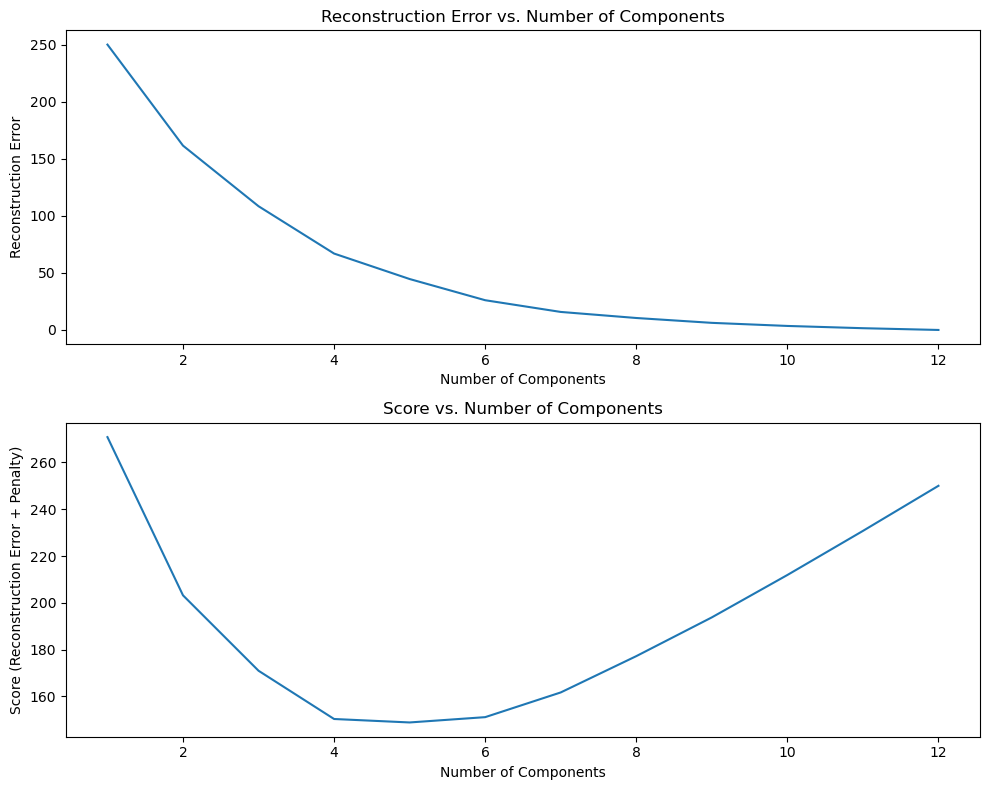

Optimal number of components: 5


In [5]:
optimal_n_components = find_optimal_n_components(ki_chroma_sync.T, random_state=42, plot_reconstruction_error=True)



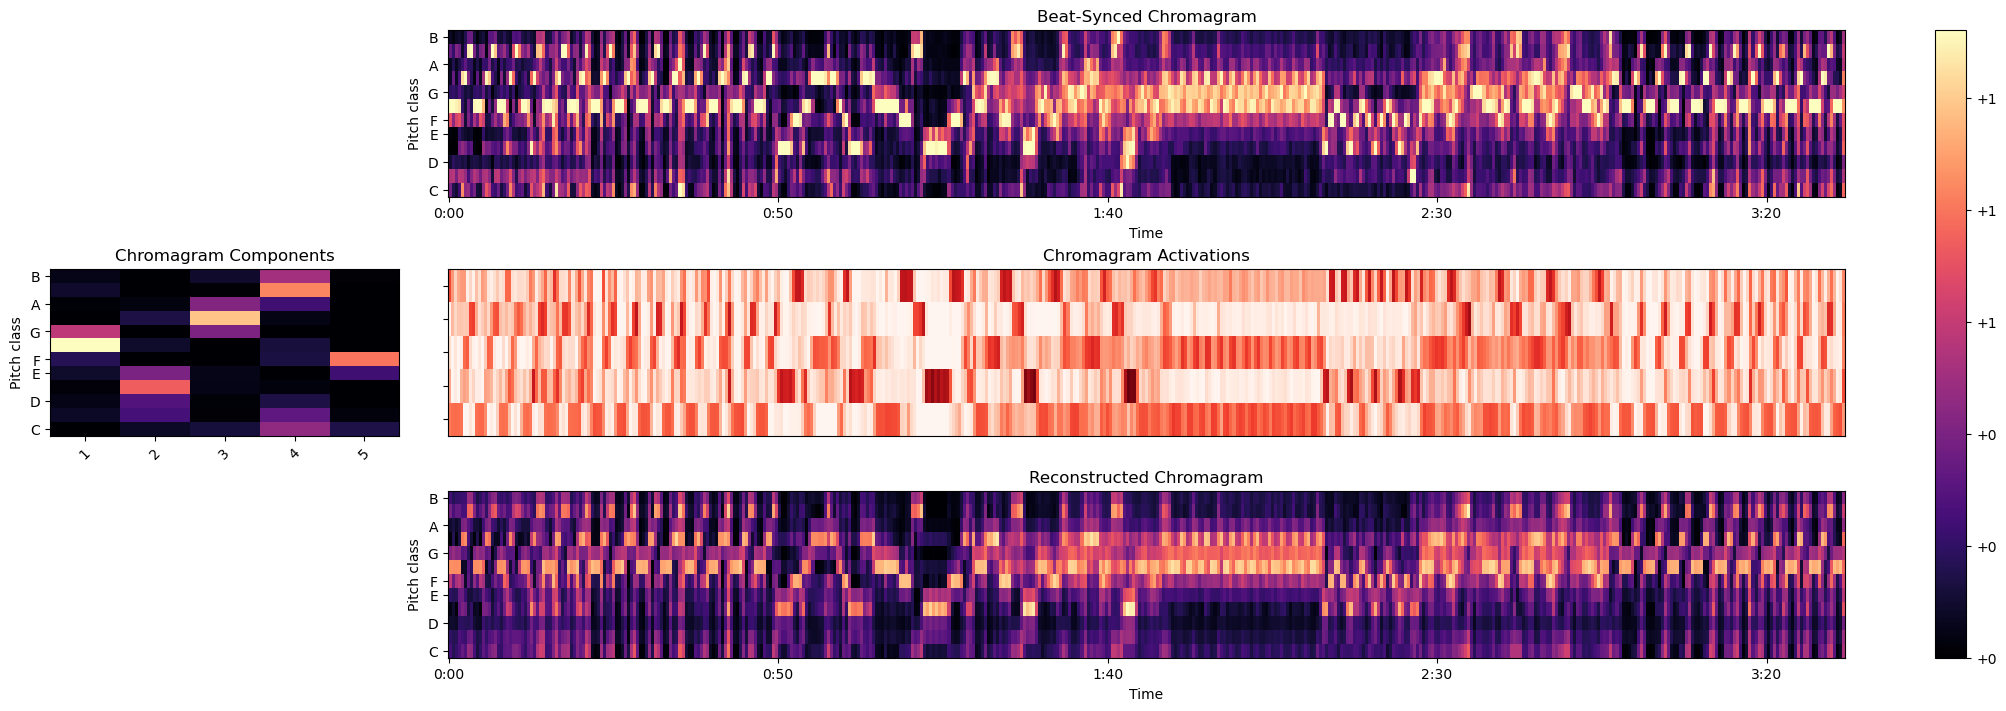

In [6]:
# Perform NMF decomposition using sklearn
nmf = NMF(n_components=optimal_n_components, max_iter=5000, init='nndsvd')
chroma_acts = nmf.fit_transform(chroma_sync.T).T
chroma_comps = (nmf.components_).T

# Define the layout for subplots
layout = [
    ['.', 'A', 'A', 'A', 'A'],
    ['B', 'C', 'C', 'C', 'C'],
    ['.', 'D', 'D', 'D', 'D']
]

# Create the subplots with specified figure size
fig, ax = plt.subplot_mosaic(layout, figsize=(20, 7), constrained_layout=True)

# Display the original chroma_sync
librosa.display.specshow(chroma_sync, y_axis='chroma', x_axis='time', ax=ax['A'],
                         sr=sr, hop_length=hop_length, x_coords=beat_grid_times)
ax['A'].set(title='Beat-Synced Chromagram')

# Display the components
librosa.display.specshow(chroma_comps, y_axis='chroma', ax=ax['B'], sr=sr, hop_length=hop_length)
ax['B'].set(title='Chromagram Components')
# Set custom x-tick labels to denote component numbers
ax['B'].set_xticks(np.arange(chroma_comps.shape[1]))
ax['B'].set_xticklabels([f"{i+1}" for i in range(chroma_comps.shape[1])])
ax['B'].tick_params(axis='x', rotation=45)

# Display the activations with a red color map
librosa.display.specshow(chroma_acts, ax=ax['C'], cmap='Reds', x_coords=np.arange(chroma_acts.shape[1]))
ax['C'].set(ylabel='Component number', title='Chromagram Activations')
# Set custom y-tick labels to denote component numbers
ax['C'].set_yticks(np.arange(chroma_acts.shape[0]))
ax['C'].set_yticklabels([f"{i+1}" for i in range(chroma_acts.shape[0])])
ax['C'].label_outer()

# Reconstruct the chroma_sync from the components and activations
chroma_sync_approx = chroma_comps @ chroma_acts

# Display the reconstructed chroma_sync
img = librosa.display.specshow(chroma_sync_approx, y_axis='chroma', x_axis='time', ax=ax['D'],
                               sr=sr, hop_length=hop_length, x_coords=beat_grid_times)
ax['D'].set(title='Reconstructed Chromagram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])

# Add a colorbar to the figure
fig.colorbar(img, ax=list(ax.values()), format="%+2.f")

# Show the plot
plt.show()

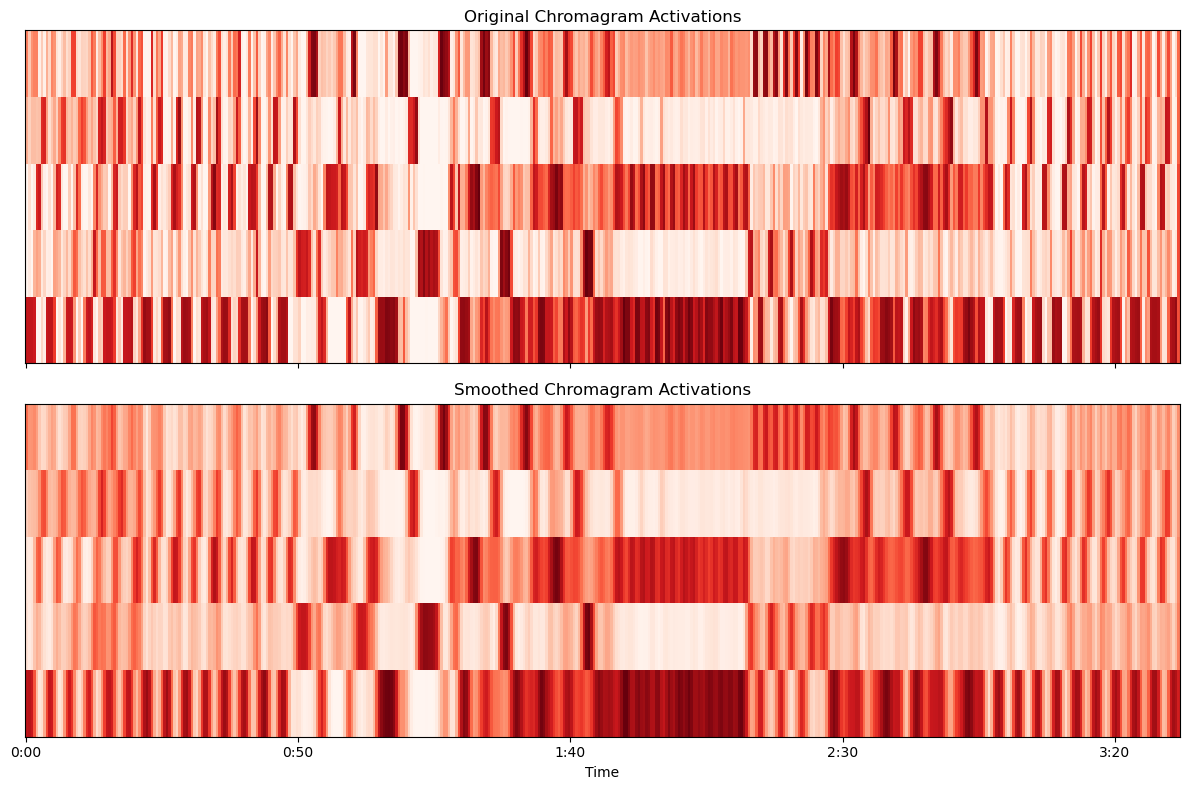

In [15]:
chroma_acts_norm = (chroma_acts - chroma_acts.min(axis=1, keepdims=True)) / (chroma_acts.max(axis=1, keepdims=True) - chroma_acts.min(axis=1, keepdims=True))
chroma_acts_smooth = gaussian_filter1d(chroma_acts_norm, sigma=1, axis=1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the original activations
librosa.display.specshow(chroma_acts_norm, x_axis='time', ax=ax1, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='Reds')
ax1.set_title('Original Chromagram Activations')
ax1.label_outer()

# Plot the smoothed activations
librosa.display.specshow(chroma_acts_smooth, x_axis='time', ax=ax2, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='Reds')
ax2.set_title('Smoothed Chromagram Activations')
ax2.label_outer()

plt.tight_layout()
plt.show()

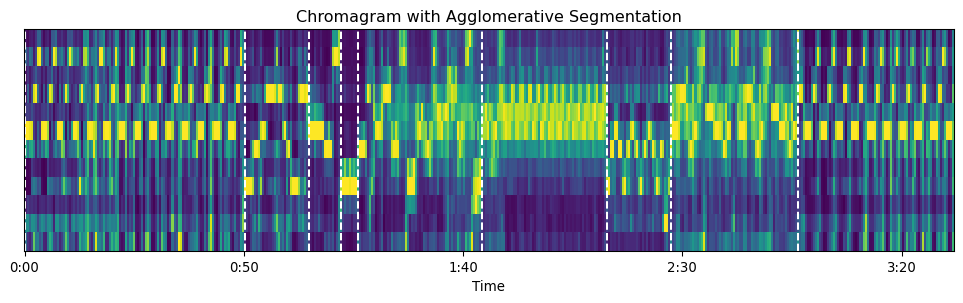

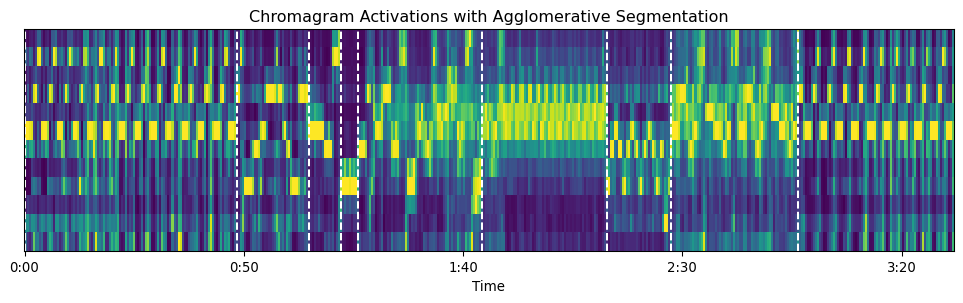

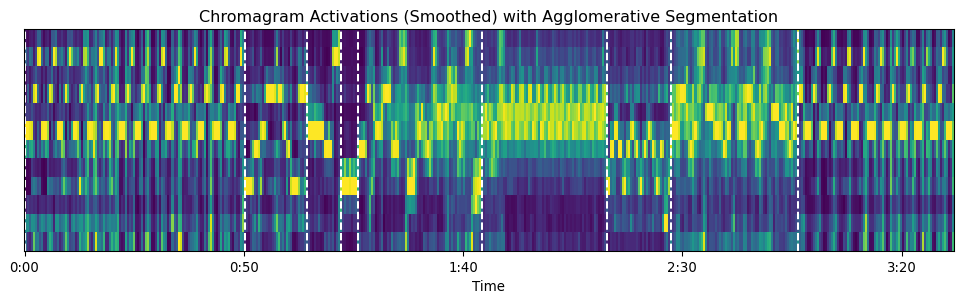

In [17]:
# Perform agglomerative clustering on chroma_acts_norm
bounds = librosa.segment.agglomerative(ki_chroma_sync, 9)
bounds_norm = librosa.segment.agglomerative(ki_chroma_acts_norm, 9)
bounds_smooth = librosa.segment.agglomerative(chroma_acts_smooth, 9)

# Convert frame indices to time values
bound_times = [beat_grid_times[idx] for idx in bounds]
bound_times_norm = [beat_grid_times[idx] for idx in bounds_norm]
bound_times_smooth = [beat_grid_times[idx] for idx in bounds_smooth]

fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)
librosa.display.specshow(chroma_sync, x_axis='time', ax=ax, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='viridis')
for time in bound_times:
    ax.axvline(time, 0, chroma_sync.shape[0], color='w', linestyle='--', label='Segment Boundary')
ax.set_title('Chromagram with Agglomerative Segmentation')
plt.show()

fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)
librosa.display.specshow(chroma_sync, x_axis='time', ax=ax, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='viridis')
for time in bound_times_norm:
    ax.axvline(time, 0, chroma_sync.shape[0], color='w', linestyle='--', label='Segment Boundary')
ax.set_title('Chromagram Activations with Agglomerative Segmentation')
plt.show()

fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)
librosa.display.specshow(chroma_sync, x_axis='time', ax=ax, sr=sr, hop_length=hop_length, x_coords=beat_grid_times, cmap='viridis')
for time in bound_times_smooth:
    ax.axvline(time, 0, chroma_sync.shape[0], color='w', linestyle='--', label='Segment Boundary')
ax.set_title('Chromagram Activations (Smoothed) with Agglomerative Segmentation')
plt.show()

In [282]:
chroma_acts_smooth = gaussian_filter1d(chroma_acts, sigma=2, axis=1)


array([106,  36,  16,   8,  62,  62,  32,  63])